# Explore the relationship between hospitalization duration and diagnosis codes

In [1]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from ast import literal_eval
from common import *
from mimic_common import *
from multiprocess import Pool
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import time


/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic


In [3]:
""" 
Read in the original dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
print(admid_diagnosis_df)

""" 
Print number of patients for each category
"""
print("female:", admid_diagnosis_df.loc[(admid_diagnosis_df['gender'] == 'F')].shape[0])
print("male:", admid_diagnosis_df.loc[(admid_diagnosis_df['gender'] == 'M')].shape[0])


         adm_type gender                                          ICD codes  \
admid                                                                         
172335  EMERGENCY      F  [403.01, 486, 582.81, 585.5, 425.4, 276.2, 710...   
173633  EMERGENCY      F  [403.01, 585.6, 583.81, 710.0, 558.9, 287.5, 2...   
174105  EMERGENCY      M               [531.00, 410.71, 285.9, 414.01, 725]   
109976  EMERGENCY      M                             [191.5, 331.4, 530.81]   
178393   ELECTIVE      M       [414.01, 411.1, 482.83, 285.9, 272.0, 305.1]   
...           ...    ...                                                ...   
172304   ELECTIVE      F       [202.80, 348.5, 784.3, 401.9, 272.0, 530.81]   
152542  EMERGENCY      M  [566, 250.62, 357.2, V58.67, 427.31, 401.9, 42...   
161999  EMERGENCY      M  [434.11, 348.5, 348.4, 430, 348.30, 997.31, 51...   
189314  EMERGENCY      F  [346.80, 784.3, 745.5, 781.94, 368.40, 781.3, ...   
168949  EMERGENCY      M  [052.9, 416.2, 201.92, 135

In [5]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var)
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var)

    return target_reps, source_reps

In [6]:
n_components = 50
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, admid_diagnosis_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=False)

(311598.8831611434,
 437852.5763781627,
 780161.856774614,
 1115338.2473082338,
 612561.8710742671,
 990269.3340301445)

In [7]:
""" 
Run multiple iterations using Poission regression
"""
score_path = os.path.join(output_dir, "exp4_poission_score.csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, admid_diagnosis_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.PoissonRegressor, iteration=100)

iteration: 0
iteration: 1
iteration: 2
cannot fit the regression model
iteration: 3
cannot fit the regression model
iteration: 4


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 5


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 6
iteration: 7
iteration: 8
iteration: 9


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 10
cannot fit the regression model
iteration: 11
iteration: 12
iteration: 13
iteration: 14


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 15
iteration: 16
iteration: 17
iteration: 18


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 19


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 20


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 21


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 22
iteration: 23
cannot fit the regression model
iteration: 24


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
cannot fit the regression model
iteration: 31
iteration: 32
iteration: 33
cannot fit the regression model
iteration: 34
iteration: 35


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 36
cannot fit the regression model
iteration: 37


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 38
iteration: 39
cannot fit the regression model
iteration: 40
iteration: 41


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 42


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 43
iteration: 44


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 45


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 46


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 47


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 48


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 49
iteration: 50
iteration: 51


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 52
iteration: 53


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 54


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 55
iteration: 56
cannot fit the regression model
iteration: 57


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 58


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 59
iteration: 60


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 61
iteration: 62
iteration: 63
cannot fit the regression model
iteration: 64


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 65
iteration: 66


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 67


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 68


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 69
cannot fit the regression model
iteration: 70
iteration: 71


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 72


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 73
iteration: 74


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 75
iteration: 76
iteration: 77


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 78
cannot fit the regression model
iteration: 79
iteration: 80


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 81
cannot fit the regression model
iteration: 82


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 83


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 84


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 85
iteration: 86


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 87
iteration: 88
iteration: 89
iteration: 90


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 91
cannot fit the regression model
iteration: 92
iteration: 93
iteration: 94
cannot fit the regression model
iteration: 95
cannot fit the regression model
iteration: 96
iteration: 97


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 98


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 99
cannot fit the regression model


array([[4.13108503e+005, 5.83572906e+005, 9.73060216e+005,
        1.76717767e+006, 8.30053905e+005, 1.26005133e+006],
       [2.32998120e+005, 3.19330254e+005, 8.15634074e+005,
        1.51075498e+006, 6.84429733e+005, 1.44258987e+006],
       [6.91431995e-310, 6.91431997e-310, 6.91431997e-310,
        6.91431992e-310, 6.91431991e-310, 6.91431989e-310],
       [6.91431997e-310, 6.91431995e-310, 6.91431991e-310,
        6.91431994e-310, 6.91431992e-310, 6.91431995e-310],
       [2.52609375e+005, 3.67926301e+005, 9.00299622e+005,
        1.42495119e+006, 7.72954180e+005, 1.30066403e+006],
       [2.03784560e+005, 2.57899607e+005, 8.28266499e+005,
        1.52431837e+006, 7.31799162e+005, 1.52272948e+006],
       [2.21334861e+005, 3.22184344e+005, 8.26660986e+005,
        1.39423676e+006, 6.18024915e+005, 1.06813177e+006],
       [3.42714341e+005, 4.89137732e+005, 8.30931867e+005,
        1.33579985e+006, 6.31680121e+005, 9.82126740e+005],
       [2.73907049e+005, 4.39260207e+005, 1.0945

<Figure size 640x480 with 0 Axes>

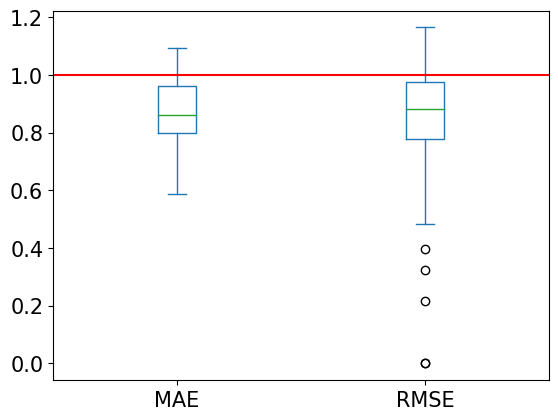

(0.862666047728569, 0.8818435628939592)

In [3]:
score_path = os.path.join(output_dir, "exp4_poisson_score.csv")

save_path = "../../outputs/mimic/exp4_poisson_res.png"
box_plot_cts_short(score_path, save_path=save_path)


In [9]:
""" 
Run multiple iterations using linear regression
"""
score_path = os.path.join(output_dir, "exp4_linear_score.csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, admid_diagnosis_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

iteration: 0


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 1
iteration: 2


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 3
iteration: 4


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 5


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 6


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 7


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 8


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 9
iteration: 10
iteration: 11


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 12


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 13


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 14
iteration: 15


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 16


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 17
iteration: 18
iteration: 19
iteration: 20


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 21


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 22


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 23


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 24


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 25


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 26
iteration: 27


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 33


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 34
iteration: 35


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 36
iteration: 37
iteration: 38


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 39
iteration: 40


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 41


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 42


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 43
iteration: 44


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 45


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 46


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 47
iteration: 48


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 49
iteration: 50
iteration: 51


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 52


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 67
iteration: 68
iteration: 69
iteration: 70


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 71


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 72


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 73


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 74
iteration: 75
iteration: 76


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 77


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 78
iteration: 79


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 80


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 81
iteration: 82


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 83
iteration: 84
iteration: 85


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 86


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 87


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 99


array([[ 339476.47877289,  487931.5632407 ,  850640.61727636,
        1325823.96376841,  791516.67226336, 1253206.05636733],
       [ 310120.43016104,  425456.98953928,  842572.71505153,
        1133714.75130909,  626008.66242959, 1069811.31670198],
       [ 444791.06103008,  632666.54402803, 1217798.81865289,
        1706397.14050685,  831200.30716438, 1515753.98376378],
       [ 310613.74219788,  430634.12505416,  919656.3600892 ,
        1229787.9675443 ,  687264.74817813,  985549.58692069],
       [ 626954.05168439, 1030498.33764636, 1272106.90815208,
        1687479.93183641,  954034.59119225, 1386951.26213327],
       [ 263352.60590678,  377928.38006409,  689487.59291351,
         950637.91839833,  529303.31033133,  749679.65191675],
       [ 290013.53766417,  400854.0490143 ,  894903.95295857,
        1308493.31274432,  644835.17683299, 1030841.20867849],
       [ 409731.24233021,  578279.25664266,  837773.46675371,
        1639110.98596132,  736216.99361528, 1665491.17687222],


<Figure size 640x480 with 0 Axes>

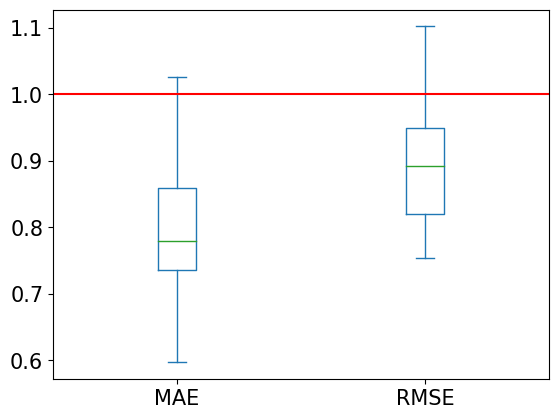

(0.7797166457971639, 0.8921478660891887)

In [4]:
score_path = os.path.join(output_dir, "exp4_linear_score.csv")
save_path = "../../outputs/mimic/exp4_linear_res.png"

box_plot_cts_short(score_path, save_path=save_path)

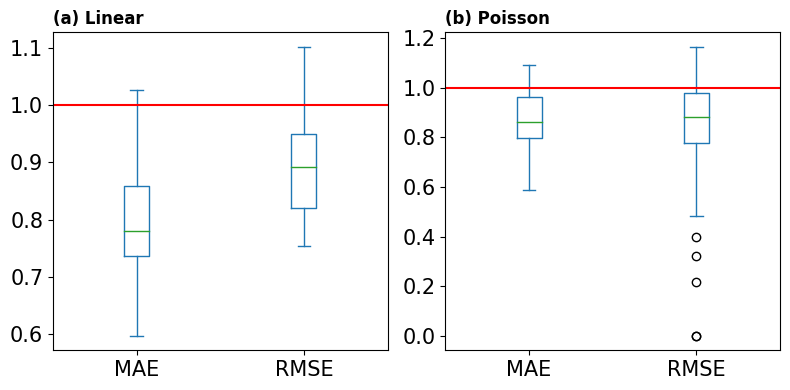

In [33]:
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(8)

# plt.subplot(1,2,1)
score_path = os.path.join(output_dir, "exp4_linear_score.csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]


# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[0])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=15)
ax.set_title("(a) Linear", fontweight='bold', loc='left')

######################################################

score_path = os.path.join(output_dir, "exp4_poisson_score.csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]


# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[1])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=15)
plt.title("(b) Poisson", fontweight='bold', loc='left')
plt.tight_layout()

save_path = os.path.join(output_dir, "exp4_res.pdf")
plt.savefig(save_path, bbox_inches='tight')
plt.show()